In [80]:
import surveysim as ssim

import geopandas as gpd
from scipy.stats._distn_infrastructure import rv_frozen


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Build `Area`

### From shapefile

In [2]:
area = ssim.Area.from_shapefile('test_area', '../tests/test_datasets/shapefiles/areas/leiap_field1.shp')

{'name': 'test_area',
 'vis': 1.0,
 'vis_type': 'scalar',
 'shape': <shapely.geometry.polygon.Polygon at 0x1a1c728710>,
 'df':    area_name  vis                                           geometry
 0  test_area  1.0  POLYGON ((533545.664 4388841.881, 533546.214 4...}

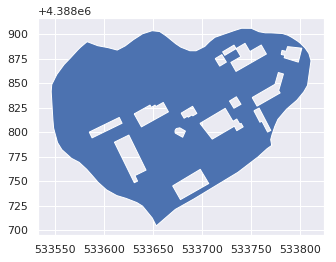

In [3]:
area.df.plot();
area.__dict__

### Set visibility to beta distribution

In [4]:
area.set_vis_beta_dist(alpha=9, beta=1)

/Users/jacobdeppen/miniconda3/envs/model/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


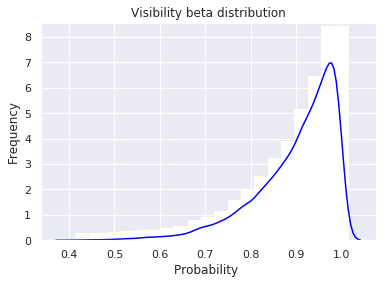

In [5]:
ax = sns.distplot(area.vis.rvs(10000),
                  bins=20,
                  kde=True,
                  hist_kws={"linewidth": 15,'alpha':1},
                  kde_kws={'color':'blue'}
                 )
ax.set(title='Visibility beta distribution', xlabel='Probability ', ylabel='Frequency');

In [6]:
area.df

,area_name,vis,geometry
0,test_area,<scipy.stats._distn_infrastructure.rv_frozen o...,"POLYGON ((533545.664 4388841.881, 533546.214 4..."


## Build `Layers`

### Poisson point process

In [7]:
ceramics = ssim.Layer.from_poisson_points(rate=.001, area=area, name='ceramics')

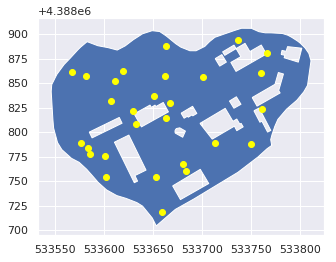

In [8]:
ceramics.df.plot(ax=area.df.plot(), color='yellow');


#### Update ideal observation rate of `ceramics`

In [9]:
ceramics.set_ideal_obs_rate_beta_dist(alpha=9.5, beta=0.5)

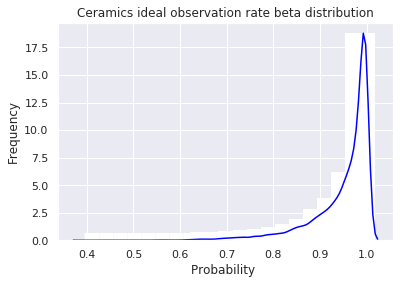

In [10]:
ax = sns.distplot(ceramics.ideal_obs_rate.rvs(10000),
                  bins=20,
                  kde=True,
                  hist_kws={"linewidth": 15,'alpha':1},
                  kde_kws={'color':'blue'}
                 )
ax.set(title='Ceramics ideal observation rate beta distribution', xlabel='Probability ', ylabel='Frequency');

#### Update time penalty of `ceramics`

When a ceramic artifact is collected, how much time does that add (in seconds) to the collection time? Here we imagine that the mean time added by one artifact is 60 seconds, but that the standard deviation is also 60 seconds. The minimum time that must be added is 10 seconds and the maximum is 600 seconds.

In [11]:
ceramics.set_time_penalty_truncnorm_dist(mean=60, sd=60, lower=10, upper=600)

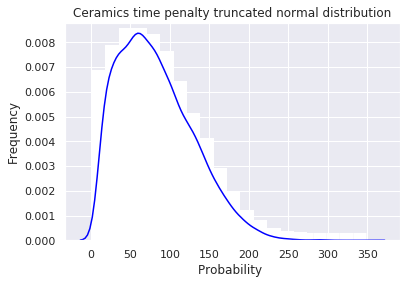

In [12]:
ax = sns.distplot(ceramics.time_penalty.rvs(10000),
                  bins=20,
                  kde=True,
                  hist_kws={"linewidth": 15,'alpha':1},
                  kde_kws={'color':'blue'}
                 )
ax.set(title='Ceramics time penalty truncated normal distribution', xlabel='Probability ', ylabel='Frequency');

In [13]:
ceramics.df.head()

,layer_name,fid,time_penalty,ideal_obs_rate,geometry
0,ceramics,ceramics_0,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533653.5937549014 4388753.665605361)
1,ceramics,ceramics_1,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533632.5697978062 4388808.162324121)
3,ceramics,ceramics_3,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533667.3125471562 4388829.662663879)
9,ceramics,ceramics_9,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533736.5366580172 4388893.853312165)
10,ceramics,ceramics_10,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533701.2833649487 4388855.974111647)


### Thomas point process

In [14]:
lithics = ssim.Layer.from_thomas_points(
    parent_rate=0.001, child_rate=5, gauss_var=5, area=area, name='lithics')

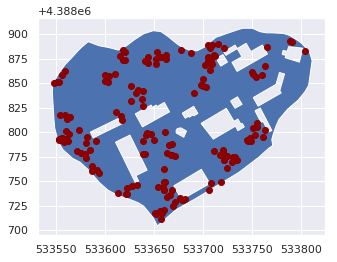

In [15]:
lithics.df.plot(ax=area.df.plot(), color='darkred');

#### Update time penalty 
...but do not update ideal observation rate. This would presume that lithic artifacts are easy to see.

In [16]:
lithics.set_time_penalty_truncnorm_dist(mean=20, sd=5, lower=5, upper=40)

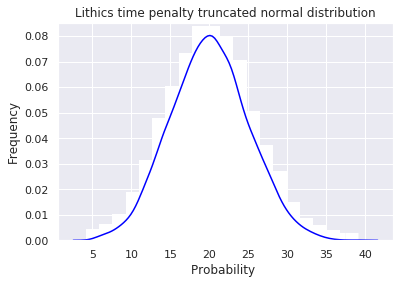

In [17]:
ax = sns.distplot(lithics.time_penalty.rvs(10000),
                  bins=20,
                  kde=True,
                  hist_kws={"linewidth": 15,'alpha':1},
                  kde_kws={'color':'blue'}
                 )
ax.set(
    title='Lithics time penalty truncated normal distribution', 
    xlabel='Probability ', ylabel='Frequency');

In [18]:
lithics.df.head()

,layer_name,fid,time_penalty,ideal_obs_rate,geometry
0,lithics,lithics_0,<scipy.stats._distn_infrastructure.rv_frozen o...,1.0,POINT (533715.1983261886 4388890.015313471)
1,lithics,lithics_1,<scipy.stats._distn_infrastructure.rv_frozen o...,1.0,POINT (533707.6251306963 4388885.59584624)
2,lithics,lithics_2,<scipy.stats._distn_infrastructure.rv_frozen o...,1.0,POINT (533658.7783632965 4388743.581452523)
3,lithics,lithics_3,<scipy.stats._distn_infrastructure.rv_frozen o...,1.0,POINT (533653.9965847607 4388744.026220392)
4,lithics,lithics_4,<scipy.stats._distn_infrastructure.rv_frozen o...,1.0,POINT (533660.1165230682 4388748.707638031)


### Matern point process
Set time penalty as a scalar (8 seconds) during creation

In [19]:
ground_stone = ssim.Layer.from_matern_points(
    parent_rate=0.001, child_rate=5, radius=15, 
    area=area, name='ground stone', time_penalty=8
)

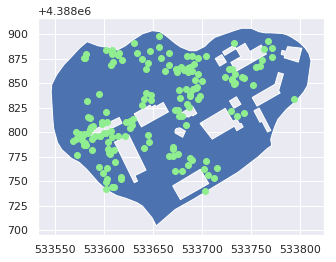

In [20]:
ground_stone.df.plot(ax=area.df.plot(), color='lightgreen');

#### Update ideal observation rate

In [21]:
ground_stone.set_ideal_obs_rate_beta_dist(alpha=9.9, beta=0.1)

In [22]:
ground_stone.df.head()

,layer_name,fid,time_penalty,ideal_obs_rate,geometry
0,ground stone,ground stone_0,8,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533614.0098147773 4388796.15965677)
1,ground stone,ground stone_1,8,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533608.4195137726 4388795.459262285)
2,ground stone,ground stone_2,8,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533606.2687771408 4388777.826932053)
3,ground stone,ground stone_3,8,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533604.8082153796 4388778.993767393)
4,ground stone,ground stone_4,8,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533603.8462098704 4388782.453409863)


### Points from a shapefile

In [23]:
coins = ssim.Layer.from_shapefile(path='../tests/test_datasets/shapefiles/layers/leiap_field1_points.shp', 
                                 area=area, name='coins', feature_type='points')

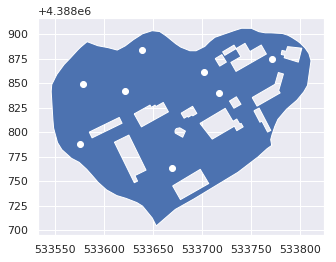

In [24]:
coins.df.plot(ax=area.df.plot(), color='white');

### Pseudorandom point process

In [25]:
tile = ssim.Layer.from_pseudorandom_points(n=15, area=area, name='tile')

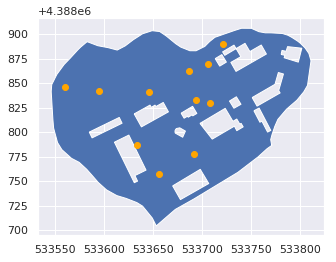

In [26]:
tile.df.plot(ax=area.df.plot(), color='orange');

### Plot all `Layer` objects

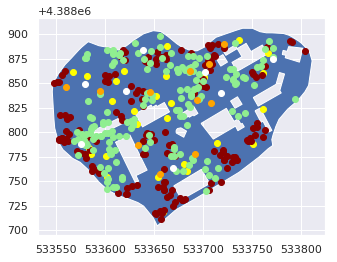

In [27]:
area_ax = area.df.plot()
ceramics.df.plot(ax=area_ax, color='yellow')
lithics.df.plot(ax=area_ax, color='darkred')
ground_stone.df.plot(ax=area_ax, color='lightgreen')
coins.df.plot(ax=area_ax, color='white')
tile.df.plot(ax=area_ax, color='orange');

## Compile `Layers` into `Assemblage`

In [28]:
assemblage = ssim.Assemblage(
    name='test_assemblage', 
    layers=[ceramics, lithics, ground_stone, coins, tile]
)

In [29]:
assemblage.df.head()

,layer_name,fid,time_penalty,ideal_obs_rate,geometry
0,ceramics,ceramics_0,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533653.5937549014 4388753.665605361)
1,ceramics,ceramics_1,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533632.5697978062 4388808.162324121)
2,ceramics,ceramics_3,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533667.3125471562 4388829.662663879)
3,ceramics,ceramics_9,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533736.5366580172 4388893.853312165)
4,ceramics,ceramics_10,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533701.2833649487 4388855.974111647)


In [30]:
assemblage.df.shape

(369, 5)

In [31]:
assemblage.df['layer_name'].unique()

array(['ceramics', 'lithics', 'ground stone', 'coins', 'tile'],
      dtype=object)

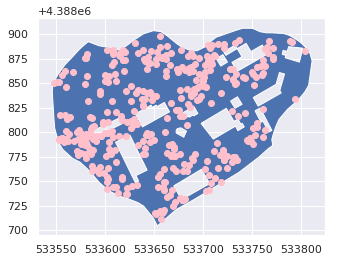

In [32]:
assemblage.df.plot(ax=area.df.plot(), color='pink');

## Build `Coverage`

In [33]:
transects = ssim.Coverage.make_transects(
    area=area, name='transects', spacing=20, sweep_width=2, 
    optimize_orient_by='area_orient', orient_axis='short',
    min_time_per_unit=0.5
)

In [34]:
transects.df.head()

,su_id,area,base_search_time,length,sweep_width,geometry
0,0,543.933425,70.069494,140.138988,2,(POLYGON ((533658.1146908473 4388709.590210016...
1,1,593.165096,74.291707,148.583414,2,(POLYGON ((533673.3662457999 4388722.767565872...
2,2,595.498503,74.791650,149.583301,2,(POLYGON ((533691.6858272522 4388733.177950755...
3,3,705.085913,88.816972,177.633943,2,"(POLYGON ((533709.58024857 4388743.971776181, ..."
4,4,704.968549,87.809033,175.618065,2,(POLYGON ((533727.4448748676 4388754.792472938...


In [35]:
transects.n_survey_units

12

In [36]:
transects.spacing

20

In [37]:
transects.survey_unit_type

'transect'

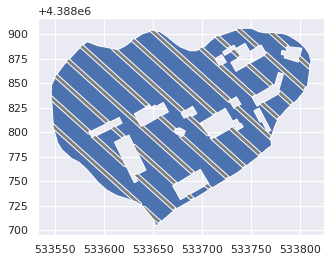

In [38]:
transects.df.plot(ax=area.df.plot(), color='gray');

In [39]:
transects.orientation

47.95354531912556

## Build `Team`

### Create `Surveyor` objects

First, add a "perfect" surveyor, who we'll call an expert

In [40]:
pi = ssim.Surveyor(name='Vivienne', surveyor_type='PI', skill=1.0, speed_penalty=0)

In [41]:
pi.df

,surveyor_name,surveyor_type,skill,speed_penalty
0,Vivienne,PI,1.0,0


In [42]:
grad1 = ssim.Surveyor(name='Dennis', surveyor_type='grad_student')
grad1.df

,surveyor_name,surveyor_type,skill,speed_penalty
0,Dennis,grad_student,1.0,0.0


Reduce the skill level just slightly for the grad student. Leave the `speed_penalty` at 0 because this student has a lot of experience with this methodology.

In [43]:
grad1.set_skill_beta_dist(alpha=9.5, beta=0.5)
grad1.df

,surveyor_name,surveyor_type,skill,speed_penalty
0,Dennis,grad_student,<scipy.stats._distn_infrastructure.rv_frozen o...,0.0


In [44]:
grad2 = ssim.Surveyor(name='Alex', surveyor_type='grad_student')
grad2.set_skill_beta_dist(alpha=9.5, beta=0.5)

Add a `speed_penalty` to this grad student who is unfamiliar with the methodology. Mean penalty is 60 seconds, with a wide standard deviation. Penalty cannot go below zero or above 300 seconds (5 minutes)

In [45]:
grad2.set_speed_penalty_truncnorm_dist(mean=60, sd=100, lower=0, upper=300)

The distribution of `speed_penalty` values for grad2 would look something like this.

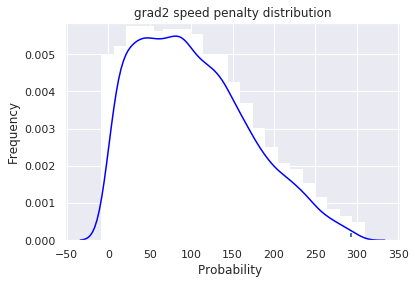

In [46]:
ax = sns.distplot(grad2.speed_penalty.rvs(10000),
                  bins=20,
                  kde=True,
                  hist_kws={"linewidth": 15,'alpha':1},
                  kde_kws={'color':'blue'}
                 )
ax.set(title='grad2 speed penalty distribution', xlabel='Probability ', ylabel='Frequency');

In [47]:
undergrad1 = ssim.Surveyor(name='Robert', surveyor_type='undergrad')
undergrad1.set_skill_beta_dist(alpha=8, beta=2)
undergrad1.set_speed_penalty_truncnorm_dist(mean=90, sd=100, lower=0, upper=300)

In [48]:
undergrad2 = ssim.Surveyor(name='Faye', surveyor_type='undergrad')
undergrad2.set_skill_beta_dist(alpha=6.5, beta=3.5)
undergrad2.set_speed_penalty_truncnorm_dist(mean=110, sd=100, lower=0, upper=400)

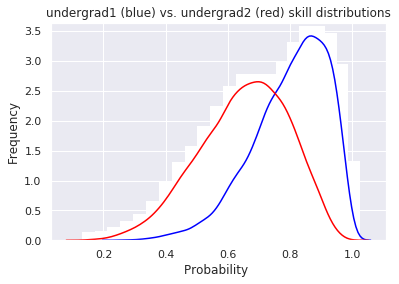

In [49]:
ax = sns.distplot(undergrad1.skill.rvs(10000),
                  bins=20,
                  kde=True,
                  hist_kws={"linewidth": 15,'alpha':1},
                  kde_kws={'color':'blue'}
                 )

sns.distplot(undergrad2.skill.rvs(10000),
                  bins=20,
                  kde=True,
                  hist_kws={"linewidth": 15,'alpha':1},
                  kde_kws={'color':'red'}
                 )
ax.set(title='undergrad1 (blue) vs. undergrad2 (red) skill distributions', xlabel='Probability ', ylabel='Frequency');

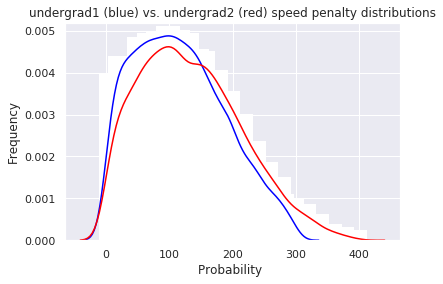

In [50]:
ax = sns.distplot(undergrad1.speed_penalty.rvs(10000),
                  bins=20,
                  kde=True,
                  hist_kws={"linewidth": 15,'alpha':1},
                  kde_kws={'color':'blue'}
                 )

sns.distplot(undergrad2.speed_penalty.rvs(10000),
                  bins=20,
                  kde=True,
                  hist_kws={"linewidth": 15,'alpha':1},
                  kde_kws={'color':'red'}
                 )
ax.set(title='undergrad1 (blue) vs. undergrad2 (red) speed penalty distributions', xlabel='Probability ', ylabel='Frequency');

In [51]:
team = ssim.Team(name='invincibles', surveyors=[pi, grad1, grad2, undergrad1, undergrad2])

In [52]:
team.df

,surveyor_name,surveyor_type,skill,speed_penalty
0,Vivienne,PI,1,0
1,Dennis,grad_student,<scipy.stats._distn_infrastructure.rv_frozen o...,0
2,Alex,grad_student,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...
3,Robert,undergrad,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...
4,Faye,undergrad,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...


## One run of the `Simulation`

### Find shapes from the `Assemblage` that intersect at least part of the `Coverage`

In [54]:
assemblage.df.shape

(369, 5)

In [55]:
transects.df.shape

(12, 6)

In [59]:
artifacts_in_coverage = gpd.sjoin(assemblage.df, transects.df, how='inner', op='intersects')

In [62]:
artifacts_in_coverage.shape

(59, 11)

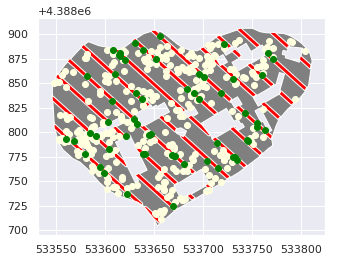

In [76]:
ax = transects.df.plot(ax=area.df.plot(color='gray'), color='red')
assemblage.df.plot(ax=ax, color='lightyellow')
artifacts_in_coverage.plot(ax=ax, color='green');

In [78]:
artifacts_in_coverage

,layer_name,fid,time_penalty,ideal_obs_rate,geometry,index_right,su_id,area,base_search_time,length,sweep_width
1,ceramics,ceramics_1,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533632.5697978062 4388808.162324121),3,3,705.085913,88.816972,177.633943,2
10,ceramics,ceramics_22,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533606.8730194013 4388831.894864665),3,3,705.085913,88.816972,177.633943,2
24,ceramics,ceramics_43,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533581.4165236189 4388857.002527384),3,3,705.085913,88.816972,177.633943,2
27,ceramics,ceramics_46,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533680.8833417683 4388767.888092861),3,3,705.085913,88.816972,177.633943,2
84,lithics,lithics_90,<scipy.stats._distn_infrastructure.rv_frozen o...,1,POINT (533668.5831061748 4388776.483812579),3,3,705.085913,88.816972,177.633943,2
85,lithics,lithics_91,<scipy.stats._distn_infrastructure.rv_frozen o...,1,POINT (533671.8876841234 4388775.25224227),3,3,705.085913,88.816972,177.633943,2
94,lithics,lithics_119,<scipy.stats._distn_infrastructure.rv_frozen o...,1,POINT (533647.3385452747 4388798.486534432),3,3,705.085913,88.816972,177.633943,2
201,ground stone,ground stone_23,8,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533645.373472607 4388796.524431197),3,3,705.085913,88.816972,177.633943,2
204,ground stone,ground stone_26,8,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533629.7833552716 4388813.408397708),3,3,705.085913,88.816972,177.633943,2
349,ground stone,ground stone_270,8,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533670.3885771064 4388775.29667528),3,3,705.085913,88.816972,177.633943,2


### Assign a `surface_visibility` to all `artifacts_in_coverage` from `Area` scalar or pull from distribution

In [79]:
if area.vis_type == 'distribution':
    # draw len(artifacts_in_coverage) samples from distribution
    pass
elif area.vis_type == 'scalar':
    # assign scalar value to all artifacts_in_coverage
    pass
else:
    # do more complicated things if it's a raster